# Gradient Boosting


In [1]:
import pandas as pd 
import numpy as np 
import warnings

warnings.filterwarnings('ignore')

## 데이터 읽어오기

In [3]:
df_bikes = pd.read_csv('./DATA/bike_rentals_cleaned.csv')
df_bikes.head()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,1.0,0.0,1,0.0,6.0,0.0,2,0.344167,0.363625,0.805833,0.160446,985
1,2,1.0,0.0,1,0.0,0.0,0.0,2,0.363478,0.353739,0.696087,0.248539,801
2,3,1.0,0.0,1,0.0,1.0,1.0,1,0.196364,0.189405,0.437273,0.248309,1349
3,4,1.0,0.0,1,0.0,2.0,1.0,1,0.200000,0.212122,0.590435,0.160296,1562
4,5,1.0,0.0,1,0.0,3.0,1.0,1,0.226957,0.229270,0.436957,0.186900,1600


## 데이터 분할
데이터를 목적(target) 항과 설명(feature) 항으로 나누고 훈련용 데이터와 테스트 데이터로 나눈다.

In [4]:
X_bikes = df_bikes.iloc[:, :-1]
y_bikes = df_bikes.iloc[:, -1]


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_bikes, y_bikes, random_state=2)

## Gradient booosting 모델을 직접 구현해 본다.

### 기본 학습자 (base learner) 생성
기본 학습자는 성능을 향상시키기 위한 정교한 모델링이 필요하지 않다.

In [7]:
from sklearn.tree import DecisionTreeRegressor

tree1 = DecisionTreeRegressor(max_depth=2, random_state=2)
tree1.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=2, random_state=2)

### 2단계 모델
1단계 모델 적합 후의 오차항을 계산하고 이 오차항을 목표변수로 하는 2단계 모델을 생성한다. 

In [8]:
y2_train = y_train - tree1.predict(X_train)

In [9]:
tree2 = DecisionTreeRegressor(max_depth=2, random_state=2)
tree2.fit(X_train, y2_train)

DecisionTreeRegressor(max_depth=2, random_state=2)

위의 과정을 반복하여 3단계 모델을 생성한다.

In [10]:
y3_train = y2_train - tree2.predict(X_train)

tree3 = DecisionTreeRegressor(max_depth=2, random_state=2)
tree3.fit(X_train, y3_train)

DecisionTreeRegressor(max_depth=2, random_state=2)

### 테스트 결과
각 단계에서의 예측값들을 계산하고 전체 예측값을 계산한다.


In [11]:

y1_pred = tree1.predict(X_test)
y2_pred = tree2.predict(X_test)
y3_pred = tree3.predict(X_test)

y_pred = y1_pred + y2_pred + y3_pred

### MSE (maen squared error) 계산


In [12]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, y_pred)**0.5

911.0479538776444

## scikit-learn 을 이용한 gradient boosting

In [13]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(max_depth=2, n_estimators=3, random_state=2, learning_rate=1.0)

In [14]:
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)
mean_squared_error(y_test, y_pred)**0.5

911.0479538776439

n_estimators 의 값 변경


In [15]:
gbr = GradientBoostingRegressor(max_depth=2, n_estimators=30, random_state=2, learning_rate=1.0)
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)
mean_squared_error(y_test, y_pred)**0.5

857.1072323426944

n_estimators 의 값을 300으로 설정한 경우

In [16]:
gbr = GradientBoostingRegressor(max_depth=2, n_estimators=300, random_state=2, learning_rate=1.0)
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)
mean_squared_error(y_test, y_pred)**0.5

936.3617413678853

오히려 `MSE` 값이 증가하는 현상이 발생하였다. 아마도 `learning_rate` 파라미터의 값이 문제가 아닐까?

`learning_rate`을 디폴트 값으로 변경 (`learning_rate=0.1`)

In [19]:
gbr = GradientBoostingRegressor(max_depth=2, n_estimators=300, random_state=2, learning_rate=0.1)
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)
mean_squared_error(y_test, y_pred)**0.5

653.7456840231495

## 하이퍼파라미터 수정

### learning_rate

`learning_rate`은 **shrinkage** 로도 알려져 있으며 각 트리의 기여도가 너무 크지 않도록 조절하는 역할을 한다. `n_estimators` 파라미터의 값이 커지면 `learning_rate`의 값을 더 작게 해야 한다.

다음과 같이 적절한 `learning_rate`을 찾을 수 있다.

In [26]:
learning_rate_values = [0.001, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.5, 1]
rmse_values = []
for value in learning_rate_values:
    gbr = GradientBoostingRegressor(max_depth=2, n_estimators=30, random_state=2, learning_rate=value)
    gbr.fit(X_train, y_train)
    y_pred = gbr.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred)**0.5
    rmse_values.append(rmse)
    print('Learning Rate: ', value, ', Score: ', rmse)

Learning Rate:  0.001 , Score:  1942.4494112631814
Learning Rate:  0.01 , Score:  1631.1821883207658
Learning Rate:  0.05 , Score:  1020.2704182412101
Learning Rate:  0.1 , Score:  816.8923095641749
Learning Rate:  0.15 , Score:  758.7146982297297
Learning Rate:  0.2 , Score:  723.2195140241369
Learning Rate:  0.3 , Score:  705.0648962066227
Learning Rate:  0.5 , Score:  712.0147889111909
Learning Rate:  1 , Score:  857.1072323426944


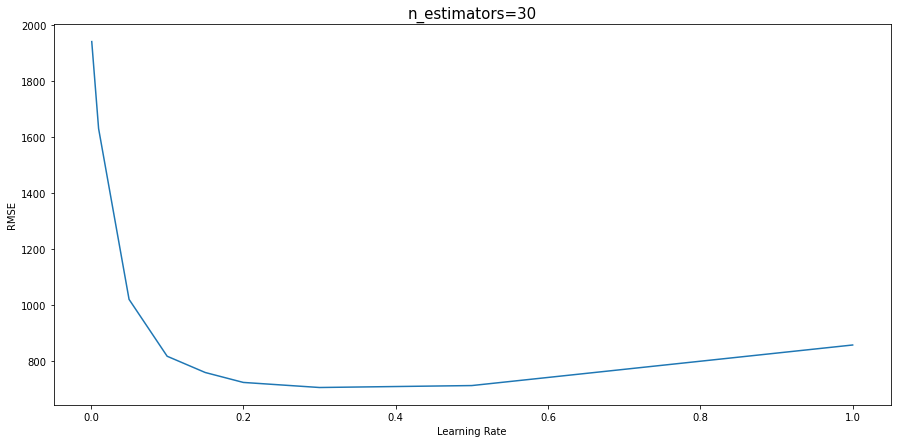

In [27]:
import matplotlib.pyplot as plt 



plt.figure(figsize=(15,7))
plt.plot(learning_rate_values, rmse_values)
plt.xlabel('Learning Rate')
plt.ylabel('RMSE')
plt.title('n_estimators=30', fontsize=15)
#plt.savefig('Random_Forest_Warm_Start', dpi=325)
plt.show()

Learning Rate:  0.001 , Score:  1633.0261400367258
Learning Rate:  0.01 , Score:  831.5430182728547
Learning Rate:  0.05 , Score:  685.0192988749717
Learning Rate:  0.1 , Score:  653.7456840231495
Learning Rate:  0.15 , Score:  687.666134269379
Learning Rate:  0.2 , Score:  664.312804425697
Learning Rate:  0.3 , Score:  689.4190385930236
Learning Rate:  0.5 , Score:  693.8856905068778
Learning Rate:  1 , Score:  936.3617413678853


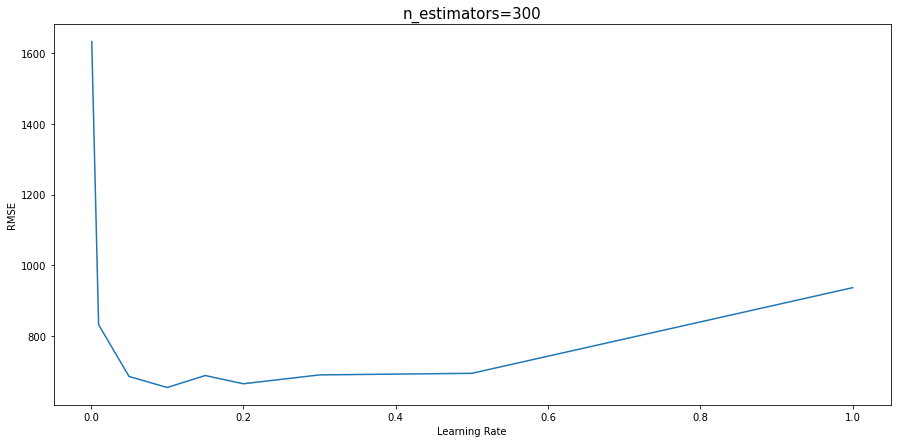

In [30]:
learning_rate_values = [0.001, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.5, 1]
rmse_values = []
for value in learning_rate_values:
    gbr = GradientBoostingRegressor(max_depth=2, n_estimators=300, random_state=2, learning_rate=value)
    gbr.fit(X_train, y_train)
    y_pred = gbr.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred)**0.5
    rmse_values.append(rmse)
    print('Learning Rate: ', value, ', Score: ', rmse)

plt.figure(figsize=(15,7))
plt.plot(learning_rate_values, rmse_values)
plt.xlabel('Learning Rate')
plt.ylabel('RMSE')
plt.title('n_estimators=300', fontsize=15)
#plt.savefig('Random_Forest_Warm_Start', dpi=325)
plt.show()

In [28]:
learning_rate_values = [0.001, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.5, 1]
rmse_values = []
for value in learning_rate_values:
    gbr = GradientBoostingRegressor(max_depth=2, n_estimators=3000, random_state=2, learning_rate=value)
    gbr.fit(X_train, y_train)
    y_pred = gbr.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred)**0.5
    rmse_values.append(rmse)
    print('Learning Rate: ', value, ', Score: ', rmse)

Learning Rate:  0.001 , Score:  833.3969271105901
Learning Rate:  0.01 , Score:  657.6148014941521
Learning Rate:  0.05 , Score:  682.9065694015884
Learning Rate:  0.1 , Score:  672.9003273253688
Learning Rate:  0.15 , Score:  702.6671711067352
Learning Rate:  0.2 , Score:  673.13671999295
Learning Rate:  0.3 , Score:  705.3628705117246
Learning Rate:  0.5 , Score:  704.3625015524514
Learning Rate:  1 , Score:  941.771465583258


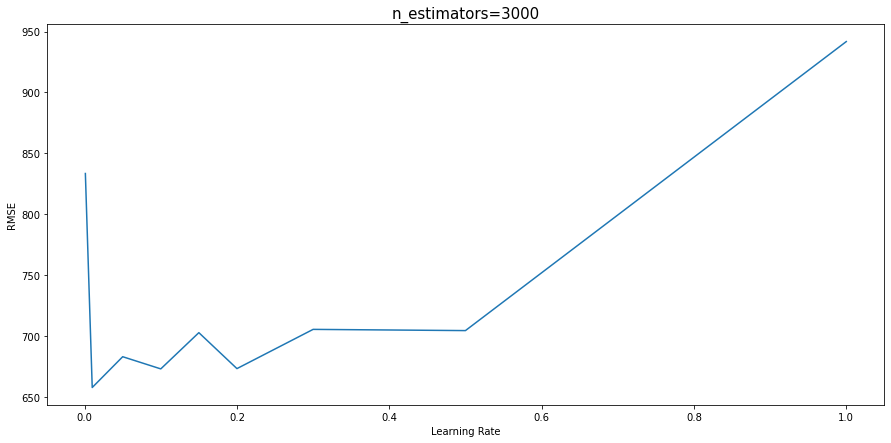

In [29]:
import matplotlib.pyplot as plt 



plt.figure(figsize=(15,7))
plt.plot(learning_rate_values, rmse_values)
plt.xlabel('Learning Rate')
plt.ylabel('RMSE')
plt.title('n_estimators=3000', fontsize=15)
#plt.savefig('Random_Forest_Warm_Start', dpi=325)
plt.show()

## Base Learner

Gradient boosting regressor의 초기 트리를 **base leaerner**라고 부른다.

### max_depth


In [32]:
depths = [None, 1, 2, 3, 4]

for depth in depths:
    gbr = GradientBoostingRegressor(max_depth=depth, n_estimators=300, random_state=2)
    gbr.fit(X_train, y_train)
    y_pred = gbr.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred)**0.5
    print('Max Depth: ', depth, ', Score : ', rmse)

Max Depth:  None , Score :  869.2783041945797
Max Depth:  1 , Score :  707.8261886858736
Max Depth:  2 , Score :  653.7456840231495
Max Depth:  3 , Score :  646.4045923317708
Max Depth:  4 , Score :  663.048387855927


### subsample

모델 생성에 사용될 샘플의 비율을 지정한다. (예: `subsample=0.8` --> 각 트리 모델을 구성할 때 80%의 표본만 사용)

In [33]:
samples = [1, 0.9, 0.8, 0.7, 0.6, 0.5]
for sample in samples:
    gbr = GradientBoostingRegressor(max_depth=3, n_estimators=300, subsample=sample, random_state=2)
    gbr.fit(X_train, y_train)
    y_pred = gbr.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred)**0.5
    print('Subsample: ', sample, ', Score: ', rmse)

Subsample:  1 , Score:  646.4045923317708
Subsample:  0.9 , Score:  620.1819001443569
Subsample:  0.8 , Score:  617.2355650565677
Subsample:  0.7 , Score:  612.9879156983139
Subsample:  0.6 , Score:  622.6385116402317
Subsample:  0.5 , Score:  626.9974073227554


- max_depth=3
- n_estimators=300
- subsample=0.7




## Randomized Search CV




In [34]:
params = {'subsample': [0.65, 0.7, 0.75],
          'n_estimators': [300, 500, 1000],
          'learning_rate':[0.05, 0.075, 0.1]}

from sklearn.model_selection import RandomizedSearchCV
gbr = GradientBoostingRegressor(max_depth=3, random_state=2)

In [35]:
rand_reg = RandomizedSearchCV(gbr, params, n_iter=10, scoring='neg_mean_squared_error', cv=5, n_jobs=-1,random_state=2)

모델 적합



In [38]:
rand_reg.fit(X_train, y_train)
best_model = rand_reg.best_estimator_
best_params = rand_reg.best_params_
print('Best params:', best_params)
best_score = np.sqrt(-rand_reg.best_score_)
y_pred = best_model.predict(X_test)
rmse_test = mean_squared_error(y_test, y_pred)**0.5
print('Test set score: {:.3f}'.format(rmse_test))

Best params: {'subsample': 0.65, 'n_estimators': 300, 'learning_rate': 0.05}
Test set score: 625.985


In [41]:
gbr = GradientBoostingRegressor(max_depth=3, n_estimators=1600, subsample=0.75, learning_rate=0.02, random_state=2)
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)
mean_squared_error(y_test, y_pred)**0.5

596.9544588974487